In [52]:
import numpy as np
import random
import gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
from IPython import display
from IPython.display import clear_output
from tqdm import tqdm
import time
from IPython.display import display, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

In [53]:
#Setting up the environment
env = gym.make('Taxi-v3')

env.reset()

#Current State
print(env.s)

print ("Number of states:", env.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3] that's actually passed to the environment

# R, G, Y, B, 0 , 1, 2, 3 in state decoding
# either go left, up, down or right, pickup or dropoff
print ("Number of actions that an agent can take:", env.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 5)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environme

334
Number of states: 500
Number of actions that an agent can take: 6
Action taken: drop
Transition probability: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
Next state: 334
Reward recieved: -10
Terminal state: False


In [54]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [55]:
env.reset()
env.step(0)

env.reset()
# print(list(env.decode(env.s))[:2])
print(list(env.decode(env.s)))
env.render()
R = [0,0]
G = [0,4]
Y = [4,0]
B = [4,3]

[2, 2, 0, 1]


We consider the goal state to be either of the four R,G,Y,B. We need a data structure to hold these 4 Q-tables.


In [56]:

seed = 42
rg = np.random.RandomState(seed)


In [93]:
from IPython.display import Image
# alpha = 0.4
alpha=  0.19751633358692788
epsilon = 0.12233772892858322
gamma = 0.9684975038393936

R_mat = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ])

Y_mat = np.array([[0,3,0,0,0],
                  [0,3,0,0,0],
                  [0,3,3,3,3],
                  [0,1,1,1,3],
                  [0,1,3,1,3]
                  ])

G_mat = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ])

B_mat = np.array([[0,0,0,0,3],
                  [0,0,0,0,3],
                  [2,2,2,0,3],
                  [1,1,1,0,3],
                  [1,1,1,0,3]
                  ])

In [96]:
# We are defining four more options here
# Option 1 move_to_R
# Option 2 move_to_G
# Option 3 move_to_Y
# Option 4 move_to_B

def move_to_R(env,state):

    ds = list(env.decode(state))[:2]
    optdone = False
    optact = R_mat[ds[0],ds[1]]

    if (ds == [0,0]):    #termination condition
        optdone = True

    return [optact,optdone]

def move_to_Y(env,state):

    ds = list(env.decode(state))[:2]
    optdone = False
    optact = Y_mat[ds[0],ds[1]]

    if (ds == [4,0]):     #termination condition
        optdone = True

    return [optact,optdone]

def move_to_G(env,state):

    ds = list(env.decode(state))[:2]
    optdone = False
    optact = G_mat[ds[0],ds[1]]

    if (ds == [0,4]):     #termination condition
        optdone = True

    return [optact,optdone]

def move_to_B(env,state):

    ds = list(env.decode(state))[:2]
    optdone = False
    optact = B_mat[ds[0],ds[1]]

    if (ds == [4,3]):     #termination condition
        optdone = True

    return [optact,optdone]

def choose_option(env, state, option):

  if option == 6:
    return move_to_R(env, state)
  elif option == 7:
    return move_to_Y(env, state)
  elif option == 8:
    return move_to_G(env, state)
  elif option == 9:
    return move_to_B(env, state)

#Now the new action space will contain
#Primitive Actions: ["south", "north", "east", "west","pick","drop"]
#Options: ["move_to_R","move_to_Y","move_to_G","move_to_B"]
#Total Actions :["south", "north", "east", "west","pick","drop","move_to_R","move_to_Y","move_to_G","move_to_B"]
#Corresponding to [0,1,2,3,4,5,6,7,8,9]


In [97]:


actions=[0,1,2,3,4,5,6,7,8,9]
#epsilon-greedy action selection function
seed = 36
rg = np.random.RandomState(seed)

def egreedy_policy(q_values,state,epsilon):
    if rg.rand() < epsilon:
        return rg.choice(actions)
    else:
        #max = np.max(q_values[state])
        #return rg.choice(np.where(q_values[state] == max)[0])
        return np.argmax(q_values[state])

In [111]:
#### SMDP Q-Learning

# Add parameters you might need here

alpha1 =  0.28
epsilon1= 0.14
gamma1 = 0.9
def SMDP(gamma, alpha, epsilon):
    # wandb.init(project = 'RLPA3', entity = 'reinforce-boys')
    # gamma = wandb.config.gamma
    # alpha = wandb.config.alpha
    # epsilon = wandb.config.epsilon

    # Iterate over 1000 episodes
    q_values_SMDP = np.zeros((500,10))
    ufd1 = np.zeros((500,10))#Update_Frequency Data structure
    Rewards = []
    for _ in range(10000):
        state = env.reset()
        done = False

        # While episode is not over
        episode_reward = 0
        while not done:

            # Choose action
            action = egreedy_policy(q_values_SMDP, state, epsilon=epsilon)

            # Checking if primitive action
            if action < 6:
                # Perform regular Q-Learning update for state-action pair

                next_state, reward, done,_ = env.step(action)
                q_values_SMDP[state, action] += alpha*(reward + gamma*np.max([q_values_SMDP[next_state, action] for action in actions]) - q_values_SMDP[state, action])
                ufd1[state,action] += 1
                state = next_state
                episode_reward += reward

            # Checking if action chosen is an option
            reward_bar = 0
            if action == 6: # action => move_to_R

                initial_state = np.copy(state)
                optdone = False
                count=0
                while (optdone == False):

                    optact,_ = move_to_R(env,state)
                    #
                    next_state, reward, done,_ = env.step(optact)

                    _,optdone = move_to_R(env,next_state)

                    # reward_bar = reward_bar +  (gamma**count)*reward
                    reward_bar = reward + gamma*reward_bar
                    count+=1
                    state = next_state
                    episode_reward += reward

                q_values_SMDP[initial_state, action] += alpha*(reward_bar + (gamma**count)*np.max([q_values_SMDP[state, action] for action in actions]) - q_values_SMDP[initial_state, action])
                ufd1[initial_state,action] += 1


            if action == 7: # action => move_to_Y option

                initial_state = np.copy(state)
                optdone = False
                count=0
                while (optdone == False):

                    optact,_ = move_to_Y(env,state)

                    next_state, reward, done,_ = env.step(optact)

                    _,optdone = move_to_Y(env,next_state)

                    # reward_bar = reward_bar +  (gamma**count)*reward
                    reward_bar = reward + gamma*reward_bar
                    count+=1

                    state = next_state
                    episode_reward += reward

                q_values_SMDP[initial_state, action] += alpha*(reward_bar + (gamma**count)*np.max([q_values_SMDP[state, action] for action in actions]) - q_values_SMDP[initial_state, action])
                ufd1[initial_state,action] += 1


            if action == 8: # action => move_to_G option

                initial_state = np.copy(state)
                optdone = False
                count=0
                while (optdone == False):

                    optact,_ = move_to_G(env,state)
                    #
                    next_state, reward, done,_ = env.step(optact)


                    _,optdone = move_to_G(env,next_state)

                    # reward_bar = reward_bar +  (gamma**count)*reward
                    reward_bar = reward + gamma*reward_bar
                    count+=1

                    state = next_state
                    episode_reward += reward

                q_values_SMDP[initial_state, action] += alpha*(reward_bar + (gamma**count)*np.max([q_values_SMDP[state, action] for action in actions]) - q_values_SMDP[initial_state, action])
                ufd1[initial_state,action] += 1


            if action == 9: # action => move_to_B option

                initial_state = np.copy(state)
                optdone = False
                count=0
                while (optdone == False):

                    optact,_ = move_to_B(env,state)
                    #
                    next_state, reward, done,_ = env.step(optact)


                    _,optdone = move_to_B(env,next_state)

                    # reward_bar = reward_bar +  (gamma**count)*reward
                    reward_bar = reward + gamma*reward_bar
                    count+=1

                    state = next_state
                    episode_reward += reward

                q_values_SMDP[initial_state, action] += alpha*(reward_bar + (gamma**count)*np.max([q_values_SMDP[state, action] for action in actions]) - q_values_SMDP[initial_state, action])
                ufd1[initial_state,action] += 1

        #wandb.log({'episode_reward': episode_reward})
        Rewards.append(episode_reward)
    return q_values_SMDP, Rewards, ufd1



#plt.plot(Rewards)


In [112]:
q_values_SMDP, Rewards, ufd1 = SMDP(gamma1, alpha1, epsilon1)

In [113]:
np.mean(Rewards[2000:])

3.505

Text(0.5, 1.0, 'SMDP reward curve')

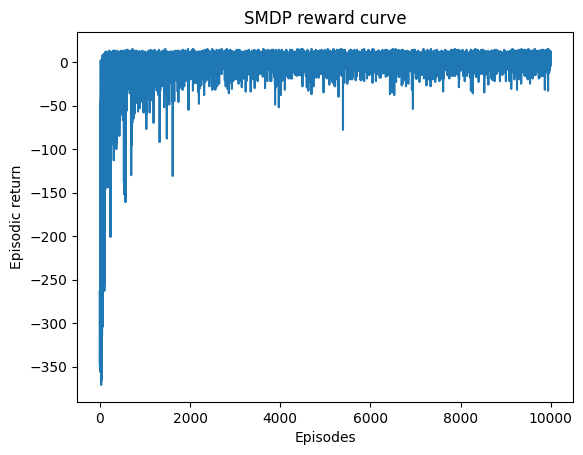

In [101]:
plt.plot(Rewards)
plt.xlabel("Episodes")
plt.ylabel("Episodic return")
plt.title("SMDP reward curve")

Text(0.5, 1.0, 'SMDP reward curve smoothed over 100 runs')

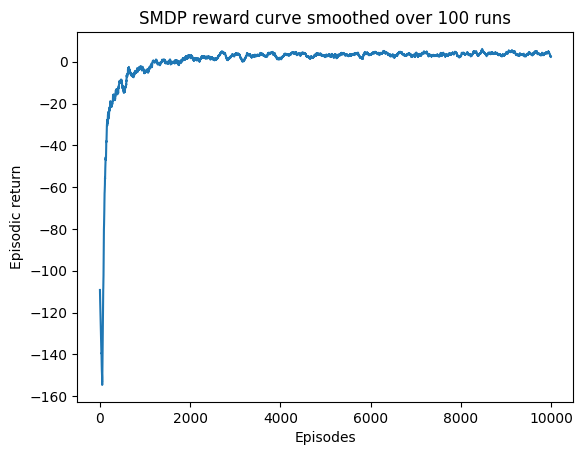

In [102]:
plt.plot(movingaverage(Rewards,100))
plt.xlabel("Episodes")
plt.ylabel("Episodic return")
plt.title("SMDP reward curve smoothed over 100 runs")

In [103]:
pass_loc = ['R','G','Y','B','in_taxi']
def render_taxi(s):
    env.s = s
    #plt.figure(3)
    #plt.clf()
    #plt.imshow(env.render(mode='rgb_array'))
    env.render()
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #env.render()
    time.sleep(2)
    clear_output(wait = True)

def drive_taxi(q_values):
    state = env.reset()
    done = False
    env.render()
    clear_output(wait = True)
    print("Passenger location : "+pass_loc[list(env.decode(env.s))[2]])
    print("Destination : "+pass_loc[list(env.decode(env.s))[3]])
    while not done:

        action = np.argmax([q_values[state]])
        if action < 6:
            state, reward, done,_ = env.step(action)
            render_taxi(state)
        if action == 6:
            optdone = False
            while(optdone == False):
                optact, optdone = move_to_R(env,state)
                next_state, reward, done,_ = env.step(optact)
                state = next_state
                render_taxi(state)
        if action == 7:
            optdone = False
            while(optdone == False):
                optact, optdone = move_to_Y(env,state)
                next_state, reward, done,_ = env.step(optact)
                state = next_state
                render_taxi(state)
        if action == 8:
            optdone = False
            while(optdone == False):
                optact, optdone = move_to_G(env,state)
                next_state, reward, done,_ = env.step(optact)
                state = next_state
                render_taxi(state)
        if action == 9:
            optdone = False
            while(optdone == False):
                optact, optdone = move_to_B(env,state)
                next_state, reward, done,_ = env.step(optact)
                state = next_state
                render_taxi(state)



In [104]:
#img = plt.imshow(env.render(mode = 'rgb_array'))
drive_taxi(q_values_SMDP)

Passenger location : G
Destination : G


In [105]:
#### Intra-Option Q-Learning

# Add parameters you might need here
# gamma = 0.9
# alpha = 0.4
alpha=  0.20
epsilon = 0.12
gamma = 0.9
def Intra(gamma, alpha, epsilon):
  # Iterate over 1000 episodes
  # gamma = wandb.config.gamma
  # alpha = wandb.config.alpha
  # epsilon = wandb.config.epsilon
  Rewards = []
  q_values_SMDP2 = np.zeros((500,10))

  ufd2 = np.zeros((500,10))#Update_Frequency Data structure
  for _ in range(10000):
      state = env.reset()
      done = False

      # While episode is not over
      episode_reward = 0
      while not done:

          # Choose action
          action = egreedy_policy(q_values_SMDP2, state, epsilon=epsilon)

          # Checking if primitive action
          if action < 6:
              # print("prim action")
              # Perform regular Q-Learning update for state-action pair

              next_state, reward, done,_ = env.step(action)
              q_values_SMDP2[state, action] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, action])
              ufd2[state,action] += 1
              episode_reward+=reward

              state = next_state

          # Checking if action chosen is an option

          if action == 6: # action => Move to R option

              # print("R")
              optdone = False
              while (optdone == False) :

                  optact,_ = move_to_R(env,state)
                  next_state, reward, done,_ = env.step(optact)
                  _,optdone = move_to_R(env,next_state)
                  episode_reward+=reward

                  q_values_SMDP2[state, optact] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, optact])
                  ufd2[state,optact] += 1

                  for option in [6,7,8,9]:
                    optact1,optdone1 = choose_option(env, state, option)
                    if optact1 == optact:
                      # print(action, option)
                      if not optdone1:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*q_values_SMDP2[next_state, option] - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1
                      else:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1

                  state = next_state





          if action == 7: # action => move to Y option


              # print("Y")
              optdone = False
              while (optdone == False) :

                  optact,_ = move_to_Y(env,state)
                  next_state, reward, done,_ = env.step(optact)
                  _,optdone = move_to_Y(env,next_state)
                  episode_reward+=reward

                  q_values_SMDP2[state, optact] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, optact])
                  ufd2[state,optact] += 1

                  for option in [6,7,8,9]:
                    optact1,optdone1 = choose_option(env, state, option)
                    if optact1 == optact:
                      if not optdone1:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*q_values_SMDP2[next_state, option] - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1
                      else:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1

                  state = next_state


          if action == 8: # action => move to G option

              # print("G")
              optdone = False
              while (optdone == False) :

                  optact,_ = move_to_G(env,state)
                  next_state, reward, done,_ = env.step(optact)
                  _,optdone = move_to_G(env,next_state)
                  episode_reward+=reward

                  q_values_SMDP2[state, optact] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, optact])
                  ufd2[state,optact] += 1

                  for option in [6,7,8,9]:
                    optact1,optdone1 = choose_option(env, state, option)
                    if optact1 == optact:
                      if not optdone1:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*q_values_SMDP2[next_state, option] - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1
                      else:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1

                  state = next_state


          if action == 9: # action => move to B option

              # print("B")
              optdone = False
              while (optdone == False) :

                  optact,_ = move_to_B(env,state)
                  next_state, reward, done,_ = env.step(optact)
                  _,optdone = move_to_B(env,next_state)
                  episode_reward+=reward

                  q_values_SMDP2[state, optact] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, optact])
                  ufd2[state,optact] += 1

                  for option in [6,7,8,9]:
                    optact1,optdone1 = choose_option(env, state, option)
                    if optact1 == optact:
                      if not optdone1:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*q_values_SMDP2[next_state, option] - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1
                      else:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1

                  state = next_state
      #wandb.log({'episode_reward': episode_reward})
      Rewards.append(episode_reward)
  return q_values_SMDP2, Rewards, ufd2


# plt.plot(Rewards)

In [78]:
q_values_SMDP2, Rewards2, ufd2 = Intra(gamma, alpha, epsilon)

In [79]:
np.mean(Rewards2[8000:])

-1.3385

Text(0.5, 1.0, 'IOQL reward curve smoothed over 100 runs')

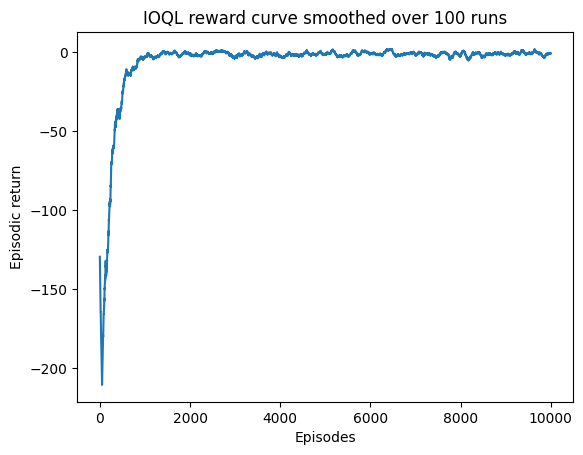

In [119]:
plt.plot(movingaverage(Rewards2,100))
plt.xlabel("Episodes")
plt.ylabel("Episodic return")
plt.title("IOQL reward curve smoothed over 100 runs")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'IOQL reward curve')

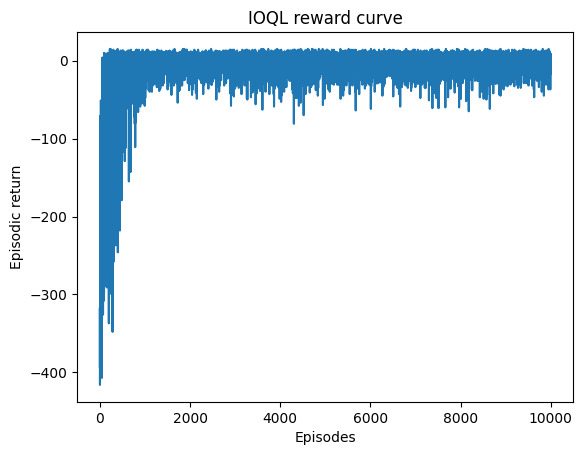

In [82]:
plt.plot(Rewards2)
plt.xlabel("Episodes")
plt.ylabel("Episodic return")
plt.title("IOQL reward curve")

In [81]:
drive_taxi(q_values_SMDP2)

Passenger location : Y
Destination : R


In [106]:
#case when passenger is at either R,G,Y,B
#To visualise lets break the task into 2 parts: pick-up and drop
op_SMDP_1 = [np.zeros((5,5)) for i in range(4)]  #Matrix to hold the optimal actions/options in each state
op_SMDP_q1 = [np.zeros((5,5)) for i in range(4)]
op_intra_1 = [np.zeros((5,5)) for i in range(4)] #cases where passengers are not in the taxi
op_intra_q1 = [np.zeros((5,5)) for i in range(4)]

op_SMDP_2 = [np.zeros((5,5)) for i in range(4)]  #Matrix to hold the optimal actions/options in each state
op_SMDP_q2 = [np.zeros((5,5)) for i in range(4)]
op_intra_2 = [np.zeros((5,5)) for i in range(4)] #cases where passenger is in the taxi
op_intra_q2 = [np.zeros((5,5)) for i in range(4)]

for i in range(500): #iterating over all states
  state = list(env.decode(i))
  if state[2] != 4:
    op_SMDP_1[state[2]][state[0],state[1]] = np.argmax(q_values_SMDP[i])
    op_SMDP_q1[state[2]][state[0],state[1]] = np.amax(q_values_SMDP[i])
    op_intra_1[state[2]][state[0],state[1]] = np.argmax(q_values_SMDP2[i])
    op_intra_q1[state[2]][state[0],state[1]] = np.amax(q_values_SMDP2[i])
  else:
    op_SMDP_2[state[3]][state[0],state[1]] = np.argmax(q_values_SMDP[i])
    op_SMDP_q2[state[3]][state[0],state[1]] = np.amax(q_values_SMDP[i])
    op_intra_2[state[3]][state[0],state[1]] = np.argmax(q_values_SMDP2[i])
    op_intra_q2[state[3]][state[0],state[1]] = np.amax(q_values_SMDP2[i])


In [107]:
def visualise_q(m1,m2, title = "1"):
  fig, ax = plt.subplots(figsize = (10,10))
  im = ax.imshow(m1, extent=[0, 10, 0, 10])
  ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im, cax=cax, orientation='vertical')
  def x_direct(a):
    if a in [0,1,4,5,6,7,8,9]:
        return 0
    elif a in [2]:
        return 1
    else:
        return -1
  def y_direct(a):
    if a in [2,3,4,5,6,7,8,9]:
      return 0
    elif a in [1]:
        return 1
    else:
        return -1
  policyx = np.vectorize(x_direct)(m2)
  policyy = np.vectorize(y_direct)(m2)
  idx = 2*np.indices((5,5))
  ax.quiver(idx[1][::-1].ravel()+ 1, idx[0][::-1].ravel()+1, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')

  for i in range(5):
    for j in range(5):
      if m2[i][j] == 4:  #pick-rectangle
        #rect = patches.Rectangle((idx[1][::-1][i][j]+0.5, idx[0][::-1][i][j]+0.5), 1, 1, linewidth=0.5, edgecolor='r', facecolor='r')
        #ax.add_patch(rect)
        ax.text(idx[1][::-1][i][j]+0.6, idx[0][::-1][i][j]+0.6 ,'Pick',color = 'r', fontsize= 20)
      if m2[i][j] == 5:  #drop-Circle
        #circ = patches.Circle((idx[1][::-1][i][j]+1, idx[0][::-1][i][j]+1), 0.5, linewidth=0.5, edgecolor='r', facecolor='r')
        #ax.add_patch(circ)
        ax.text(idx[1][::-1][i][j]+0.6, idx[0][::-1][i][j]+0.6 ,'Drop',color = 'r', fontsize= 20)
      if m2[i][j] == 6:
        ax.text(idx[1][::-1][i][j]+0.9, idx[0][::-1][i][j]+0.9 ,'R',color = 'r', fontsize= 35)

      if m2[i][j] == 7:
        ax.text(idx[1][::-1][i][j]+0.9, idx[0][::-1][i][j]+0.9 ,'Y',color = 'r', fontsize= 35)

      if m2[i][j] == 8:
        ax.text(idx[1][::-1][i][j]+0.9, idx[0][::-1][i][j]+0.9 ,'G',color = 'r', fontsize= 35)

      if m2[i][j] == 9:
        ax.text(idx[1][::-1][i][j]+0.9, idx[0][::-1][i][j]+0.9 ,'B',color = 'r', fontsize= 35)

  fig.tight_layout()
  plt.savefig(title)


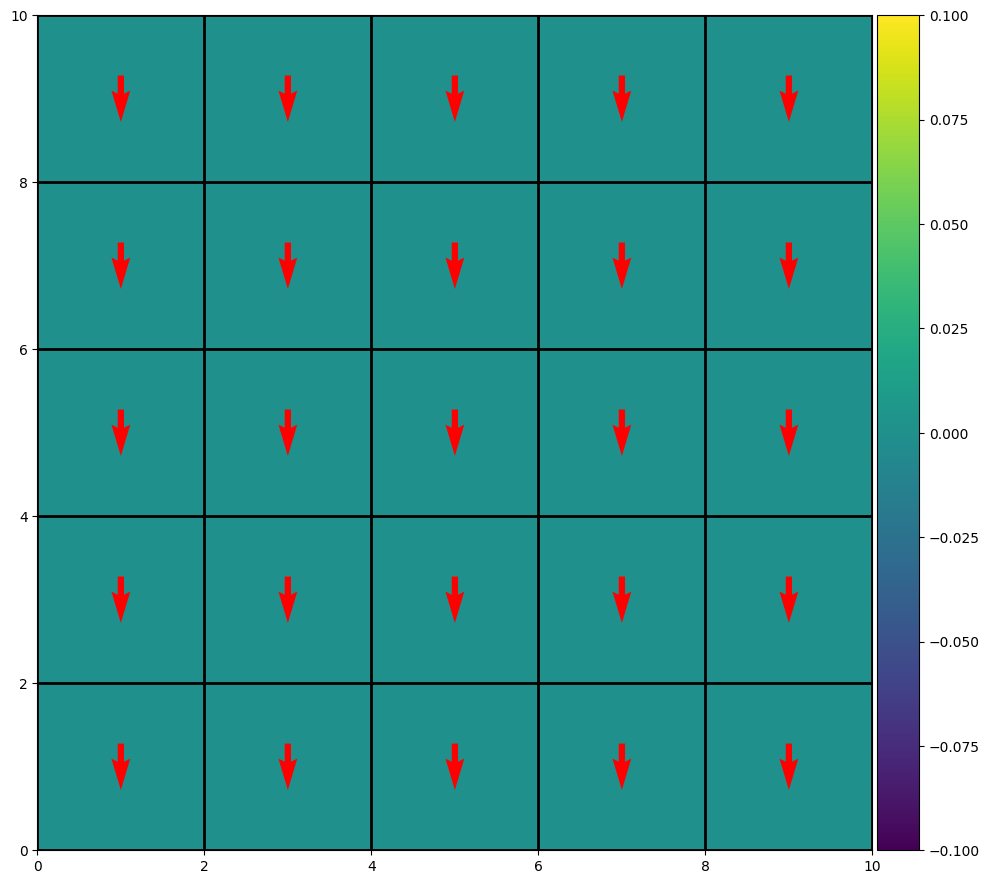

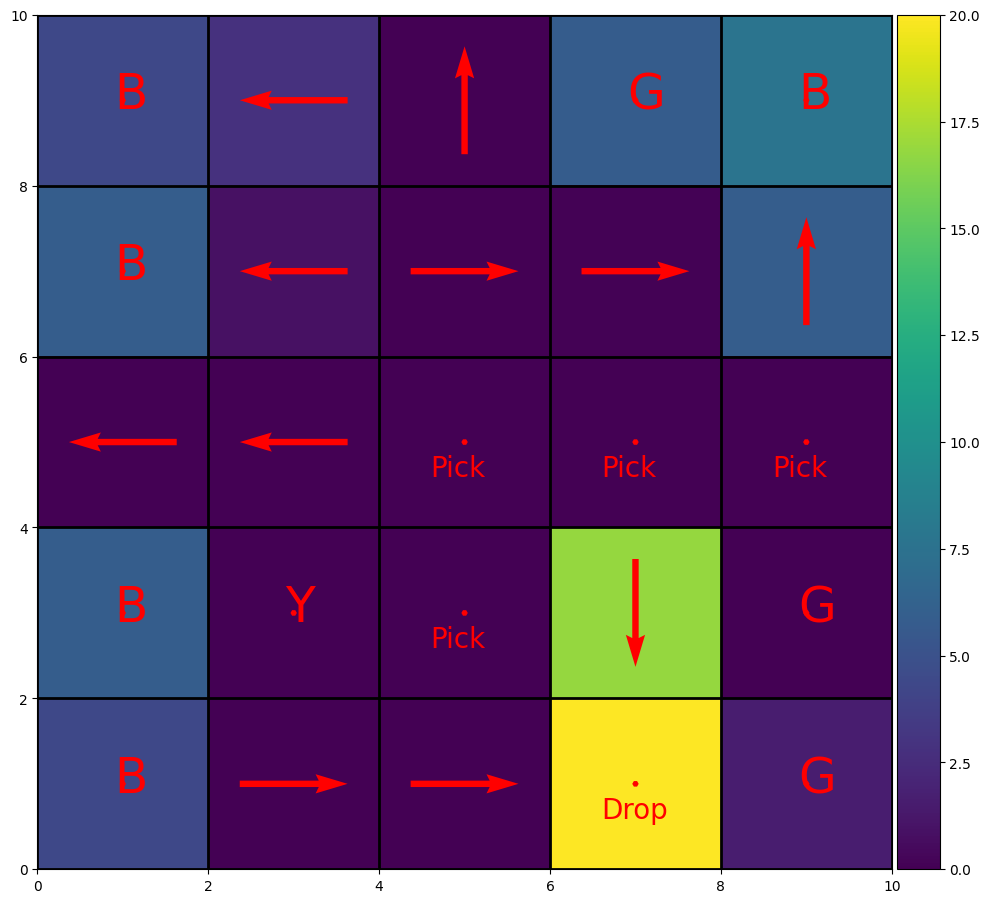

In [110]:
#put plots
visualise_q(op_SMDP_q1[3],op_SMDP_1[3], "0")
visualise_q(op_SMDP_q2[3],op_SMDP_2[3], "1")

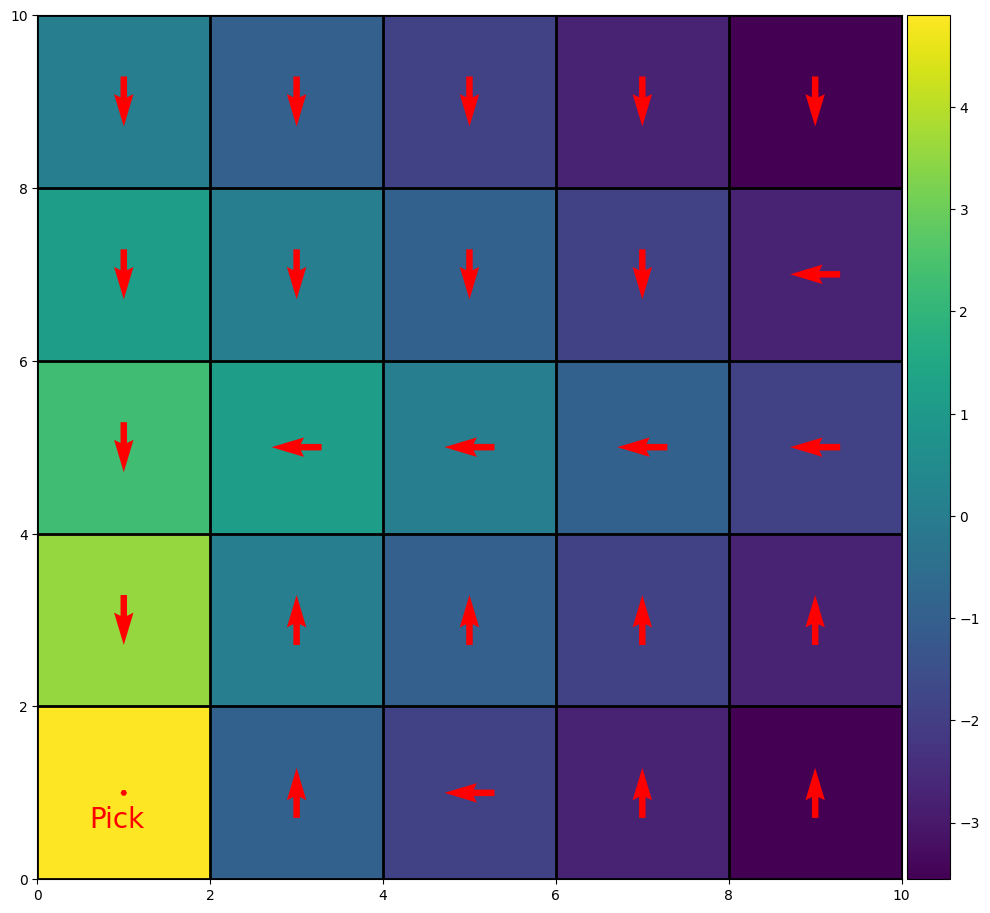

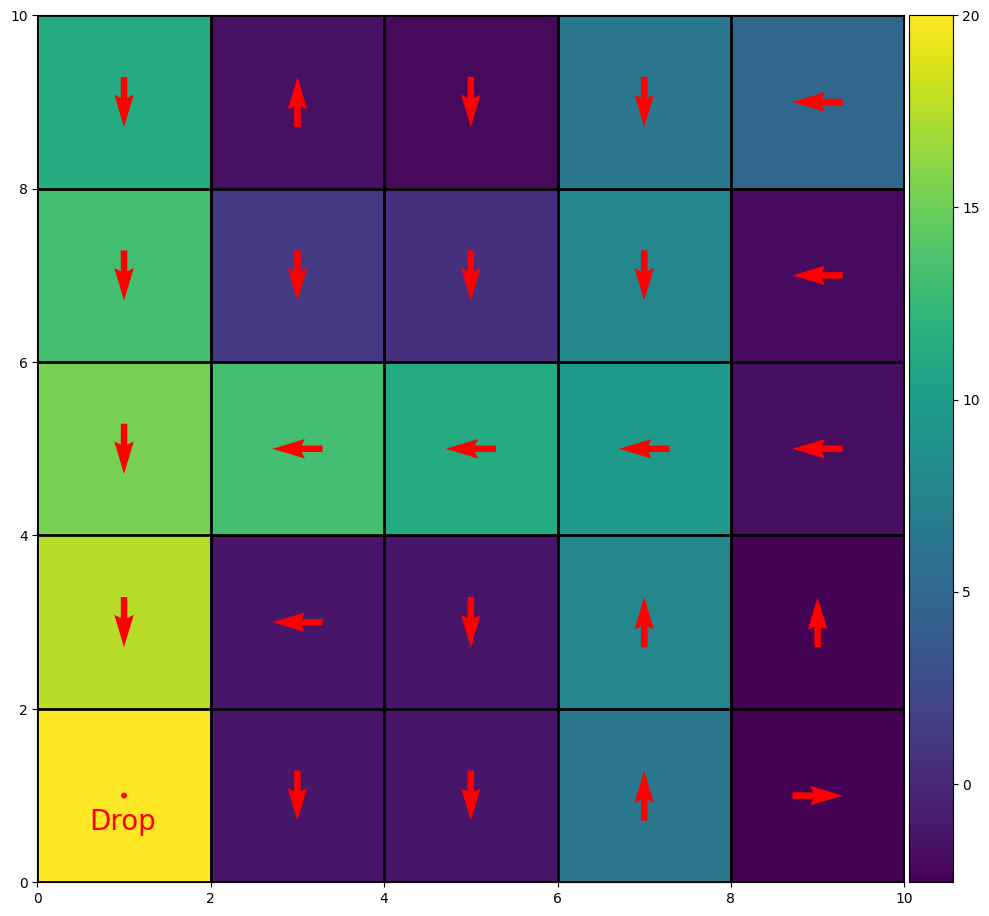

In [164]:
visualise_q(op_intra_q1[2],op_intra_1[2],"0")
visualise_q(op_intra_q2[2],op_intra_2[2],"1")

<h3> Now we experiment with another set of options </h3>

In [128]:
h_mat = np.array([[0,0,0,0,0],
                  [0,0,0,0,0],
                  [2,2,2,3,3],
                  [1,1,1,1,1],
                  [1,1,1,1,1]])

In [129]:
# We are defining four more options here
# Option 1 go to highway
# Option 2 move left on highway
# Option 3 move right on highway

def goto_hw(env,state):

    ds = list(env.decode(state))[:2]
    optdone = False
    optact = h_mat[ds[0],ds[1]]

    if (ds[0] == 2):    #termination condition(if row==2)
        optdone = True

    return [optact,optdone]

def left_hw(env,state):

    ds = list(env.decode(state))[:2]
    optdone = False
    optact = 3

    if (ds == [2,0]):     #termination condition
        optdone = True

    return [optact,optdone]

def right_hw(env,state):

    ds = list(env.decode(state))[:2]
    optdone = False
    optact = 2

    if (ds == [2,3]):     #termination condition
        optdone = True

    return [optact,optdone]

def choose_alternate_options(env, state, option):

  if option == 6:
    return goto_hw(env, state)
  if option == 7:
    return left_hw(env, state)
  if option == 8:
    return right_hw(env, state)



#Now the new action space will contain
#Primitive Actions: ["south", "north", "east", "west","pick","drop"]
#Options: ["move_to_R","move_to_Y","move_to_G","move_to_B"]
#Total Actions :["south", "north", "east", "west","pick","drop","goto_hw","left_hw","right_hw"]
#Corresponding to [0,1,2,3,4,5,6,7,8]


In [130]:

#epsilon-greedy action selection function
seed = 36
rg = np.random.RandomState(seed)

def egreedy_policy(q_values,state,epsilon):
    nstate = list(env.decode(state))[:2]
    if nstate[0]!=2:
      actions = [0,1,2,3,4,5,6]
    if nstate == [2,0]:
      actions = [0,1,2,3,4,5,8]
    if nstate == [2,1] or nstate ==[2,2] :
      actions = [0,1,2,3,4,5,7,8]
    if nstate == [2,3] or nstate ==[2,4] :
      actions = [0,1,2,3,4,5,7]

    if rg.rand() < epsilon:
        return rg.choice(actions)
    else:
        #max = np.max(q_values[state])
        #return rg.choice(np.where(q_values[state] == max)[0])
        return np.argmax(q_values[state])

In [131]:
def get_q():
  q_values_SMDP = np.zeros((500,9))
  for i in range(500):
    pos = list(env.decode(i))[:2]
    if pos[0] != 2:
      q_values_SMDP[i,7] = -100
      q_values_SMDP[i,8] = -100

    if pos == [2,0]:
      q_values_SMDP[i,7] = -100
      q_values_SMDP[i,6] = -100

    if pos == [2,1] or pos ==[2,2] :
      q_values_SMDP[i,6] = -100

    if pos == [2,3] or pos ==[2,4] :
      q_values_SMDP[i,6] = -100
      q_values_SMDP[i,8] = -100

  return q_values_SMDP

In [132]:

#### SMDP Q-Learning
actions = [0,1,2,3,4,5,6,7,8]
# Add parameters you might need here
gamma = 0.9
alpha = 0.2
epsilon=0.01
# Iterate over 1000 episodes
def SMDP(gamma,alpha,epsilon):
  q_values_SMDP =get_q()
  ufd1 = np.zeros((500,9))#Update_Frequency Data structure
  Rewards = []
  for _ in range(10000):
      state = env.reset()
      done = False

      # While episode is not over
      episode_reward = 0
      while not done:

          # Choose action
          action = egreedy_policy(q_values_SMDP, state, epsilon)

          # Checking if primitive action
          if action < 6:
              # Perform regular Q-Learning update for state-action pair

              next_state, reward, done,_ = env.step(action)
              q_values_SMDP[state, action] += alpha*(reward + gamma*np.max([q_values_SMDP[next_state, action] for action in actions]) - q_values_SMDP[state, action])
              ufd1[state,action] += 1
              state = next_state
              episode_reward += reward

          # Checking if action chosen is an option
          reward_bar = 0
          if action == 6: # action => goto_hw

              initial_state = np.copy(state)
              optdone = False
              count=0
              while (optdone == False):

                  optact,_ = goto_hw(env,state)
                  #
                  next_state, reward, done,_ = env.step(optact)

                  _,optdone = goto_hw(env,next_state)

                  reward_bar = reward_bar +  (gamma**count)*reward
                  count+=1
                  state = next_state
                  episode_reward += reward

              q_values_SMDP[initial_state, action] += alpha*(reward_bar + (gamma**count)*np.max([q_values_SMDP[state, action] for action in actions]) - q_values_SMDP[initial_state, action])
              ufd1[initial_state,action] += 1


          if action == 7: # action => left_hw option

              initial_state = np.copy(state)
              optdone = False
              count=0
              while (optdone == False):

                  optact,_ = left_hw(env,state)

                  next_state, reward, done,_ = env.step(optact)

                  _,optdone = left_hw(env,next_state)

                  reward_bar = reward_bar +  (gamma**count)*reward
                  count+=1

                  state = next_state
                  episode_reward += reward

              q_values_SMDP[initial_state, action] += alpha*(reward_bar + (gamma**count)*np.max([q_values_SMDP[state, action] for action in actions]) - q_values_SMDP[initial_state, action])
              ufd1[initial_state,action] += 1


          if action == 8: # action => right_hw option

              initial_state = np.copy(state)
              optdone = False
              count=0
              while (optdone == False):

                  optact,_ = right_hw(env,state)
                  #
                  next_state, reward, done,_ = env.step(optact)


                  _,optdone = right_hw(env,next_state)

                  reward_bar = reward_bar +  (gamma**count)*reward
                  count+=1

                  state = next_state
                  episode_reward += reward

              q_values_SMDP[initial_state, action] += alpha*(reward_bar + (gamma**count)*np.max([q_values_SMDP[state, action] for action in actions]) - q_values_SMDP[initial_state, action])
              ufd1[initial_state,action] += 1


      Rewards.append(episode_reward)

  return q_values_SMDP,Rewards,ufd1





Text(0.5, 1.0, 'SMPD reward curve')

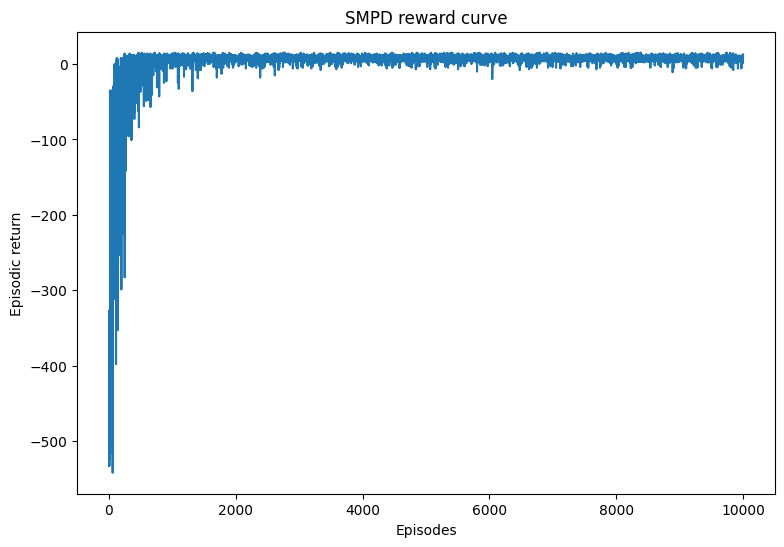

In [133]:
q_values1,rewards1,ufd1 = SMDP(gamma,alpha,epsilon)
plt.figure(figsize=(9,6))
plt.plot(rewards1)
plt.xlabel("Episodes")
plt.ylabel("Episodic return")
plt.title("SMPD reward curve")


Text(0.5, 1.0, 'SMDP reward curve averaged over 100 runs')

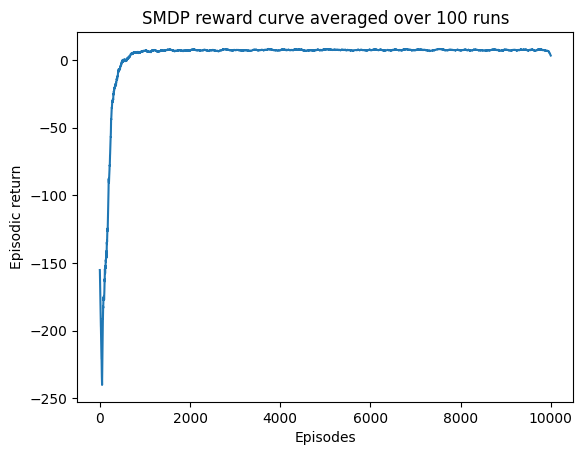

In [134]:
plt.plot(movingaverage(rewards1,100))
plt.xlabel("Episodes")
plt.ylabel("Episodic return")
plt.title("SMDP reward curve averaged over 100 runs")

In [135]:
np.mean(rewards1[8000:])

7.3425

In [136]:
#### Intra-Option Q-Learning

# Add parameters you might need here
gamma = 0.93
alpha = 0.2
epsilon=0.001
# Iterate over 1000 episodes
def intra(gamma,alpha,epsilon):
  Rewards = []
  q_values_SMDP2 = get_q()
  ufd2 = np.zeros((500,9))#Update_Frequency Data structure
  for _ in range(10000):
      state = env.reset()
      done = False

      # While episode is not over
      episode_reward = 0
      while not done:

          # Choose action
          action = egreedy_policy(q_values_SMDP2, state, epsilon)

          # Checking if primitive action
          if action < 6:
              # Perform regular Q-Learning update for state-action pair

              next_state, reward, done,_ = env.step(action)
              q_values_SMDP2[state, action] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, action])
              ufd2[state,action] += 1
              episode_reward+=reward

              state = next_state

          # Checking if action chosen is an option

          if action == 6: # action => goto highway option

              optdone = False
              while (optdone == False) :

                  optact,_ = goto_hw(env,state)
                  next_state, reward, done,_ = env.step(optact)
                  _,optdone = goto_hw(env,next_state)
                  episode_reward+=reward

                  q_values_SMDP2[state, optact] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, optact])
                  ufd2[state,optact] += 1

                  for option in [6,7,8]:
                    optact1,optdone1 = choose_alternate_options(env, state, option)
                    if optact1 == optact:
                      if not optdone1:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*q_values_SMDP2[next_state, option] - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1
                      else:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1

                  state = next_state





          if action == 7: # action => move left of highway option

              optdone = False
              while (optdone == False) :

                  optact,_ = left_hw(env,state)
                  next_state, reward, done,_ = env.step(optact)
                  _,optdone = left_hw(env,next_state)
                  episode_reward+=reward

                  q_values_SMDP2[state, optact] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, optact])
                  ufd2[state,optact] += 1

                  for option in [6,7,8]:
                    optact1,optdone1 = choose_alternate_options(env, state, option)
                    if optact1 == optact:
                      if not optdone1:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*q_values_SMDP2[next_state, option] - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1
                      else:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1

                  state = next_state


          if action == 8: # action => move right of highway option

              optdone = False
              while (optdone == False) :

                  optact,_ = right_hw(env,state)
                  next_state, reward, done,_ = env.step(optact)
                  _,optdone = right_hw(env,next_state)
                  episode_reward+=reward

                  q_values_SMDP2[state, optact] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, optact])
                  ufd2[state,optact] += 1

                  for option in [6,7,8]:
                    optact1,optdone1 = choose_alternate_options(env, state, option)
                    if optact1 == optact:
                      if not optdone1:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*q_values_SMDP2[next_state, option] - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1
                      else:
                        q_values_SMDP2[state, option] += alpha*(reward + gamma*np.max([q_values_SMDP2[next_state, action] for action in actions]) - q_values_SMDP2[state, option])
                        ufd2[state,option] += 1


                  state = next_state


      Rewards.append(episode_reward)

  return q_values_SMDP2,Rewards,ufd2




In [137]:
q_values2,rewards2,ufd2 = intra(gamma,alpha,epsilon)


Text(0.5, 1.0, 'IOQL reward curve')

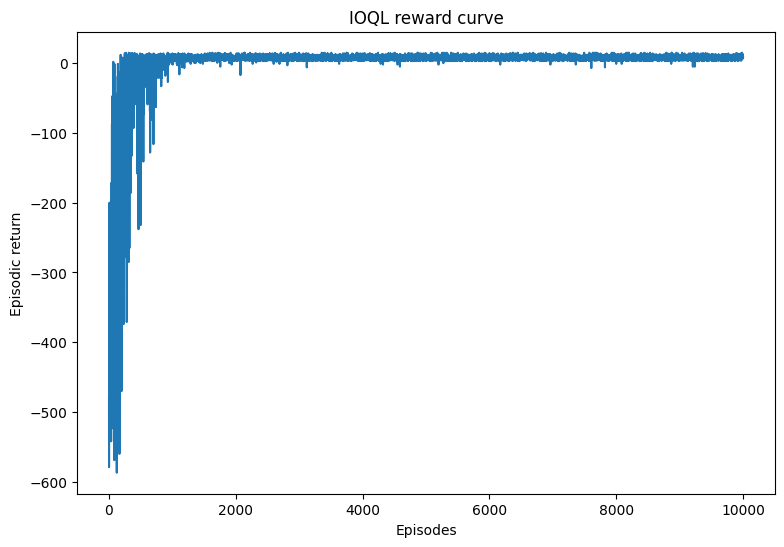

In [142]:
plt.figure(figsize=(9,6))
plt.plot(rewards2)
plt.xlabel("Episodes")
plt.ylabel("Episodic return")
plt.title("IOQL reward curve")

Text(0.5, 1.0, 'IOQL reward curve averaged over 100 runs')

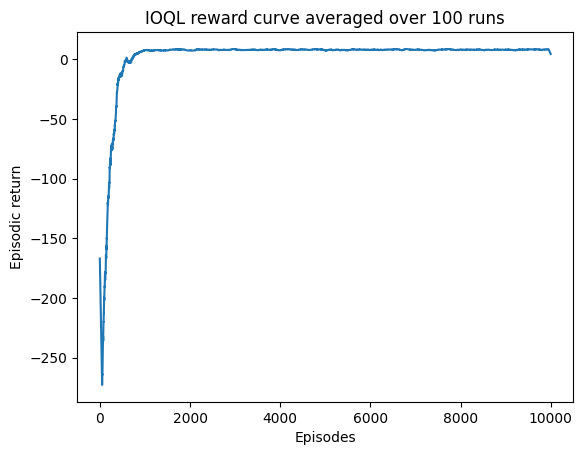

In [143]:
plt.plot(movingaverage(rewards2, 100))
plt.xlabel("Episodes")
plt.ylabel("Episodic return")
plt.title("IOQL reward curve averaged over 100 runs")

In [144]:
np.mean(rewards2[8000:])

7.958

In [145]:
#case when passenger is at either R,G,Y,B
#To visualise lets break the task into 2 parts: pick-up and drop
op_SMDP_1 = [np.zeros((5,5)) for i in range(4)]  #Matrix to hold the optimal actions/options in each state
op_SMDP_q1 = [np.zeros((5,5)) for i in range(4)]
ufd_SMDP_1 = [np.zeros((5,5)) for i in range(4)]
op_intra_1 = [np.zeros((5,5)) for i in range(4)] #cases where passengers are not in the taxi
op_intra_q1 = [np.zeros((5,5)) for i in range(4)]
ufd_intra_1 = [np.zeros((5,5)) for i in range(4)]

op_SMDP_2 = [np.zeros((5,5)) for i in range(4)]  #Matrix to hold the optimal actions/options in each state
op_SMDP_q2 = [np.zeros((5,5)) for i in range(4)]
ufd_SMDP_2 = [np.zeros((5,5)) for i in range(4)]
op_intra_2 = [np.zeros((5,5)) for i in range(4)] #cases where passenger is in the taxi
op_intra_q2 = [np.zeros((5,5)) for i in range(4)]
ufd_intra_2 = [np.zeros((5,5)) for i in range(4)]

for i in range(500): #iterating over all states
  state = list(env.decode(i))
  if state[2] != 4:
    op_SMDP_1[state[2]][state[0],state[1]] = np.argmax(q_values1[i])
    op_SMDP_q1[state[2]][state[0],state[1]] = np.amax(q_values1[i])
    ufd_SMDP_1[state[2]][state[0],state[1]] = np.sum(ufd1[i])
    op_intra_1[state[2]][state[0],state[1]] = np.argmax(q_values2[i])
    op_intra_q1[state[2]][state[0],state[1]] = np.amax(q_values2[i])
    ufd_intra_1[state[2]][state[0],state[1]] = np.sum(ufd2[i])
  else:
    op_SMDP_2[state[3]][state[0],state[1]] = np.argmax(q_values1[i])
    op_SMDP_q2[state[3]][state[0],state[1]] = np.amax(q_values1[i])
    ufd_SMDP_2[state[3]][state[0],state[1]] = np.sum(ufd1[i])
    op_intra_2[state[3]][state[0],state[1]] = np.argmax(q_values2[i])
    op_intra_q2[state[3]][state[0],state[1]] = np.amax(q_values2[i])
    ufd_intra_2[state[3]][state[0],state[1]] = np.sum(ufd2[i])


In [150]:
def visualise_q(m1,m2, title = '1'):
  fig, ax = plt.subplots(figsize = (10,10))
  im = ax.imshow(m1, extent=[0, 10, 0, 10])
  ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im, cax=cax, orientation='vertical')
  def x_direct(a):
    if a in [0,1,4,5,6,7,8]:
        return 0
    elif a in [2]:
        return 1
    else:
        return -1
  def y_direct(a):
    if a in [2,3,4,5,6,7,8]:
      return 0
    elif a in [1]:
        return 1
    else:
        return -1
  policyx = np.vectorize(x_direct)(m2)
  policyy = np.vectorize(y_direct)(m2)
  idx = 2*np.indices((5,5))
  ax.quiver(idx[1][::-1].ravel()+ 1, idx[0][::-1].ravel()+1, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')

  for i in range(5):
    for j in range(5):
      if m2[i][j] == 4:  #pick-rectangle
        #rect = patches.Rectangle((idx[1][::-1][i][j]+0.5, idx[0][::-1][i][j]+0.5), 1, 1, linewidth=0.5, edgecolor='r', facecolor='r')
        #ax.add_patch(rect)
        ax.text(idx[1][::-1][i][j]+0.6, idx[0][::-1][i][j]+0.6 ,'Pick',color = 'r', fontsize= 20)
      if m2[i][j] == 5:  #drop-Circle
        #circ = patches.Circle((idx[1][::-1][i][j]+1, idx[0][::-1][i][j]+1), 0.5, linewidth=0.5, edgecolor='r', facecolor='r')
        #ax.add_patch(circ)
        ax.text(idx[1][::-1][i][j]+0.6, idx[0][::-1][i][j]+0.6 ,'Drop',color = 'r', fontsize= 20)
      if m2[i][j] == 6:
        ax.text(idx[1][::-1][i][j]+0.9, idx[0][::-1][i][j]+0.9 ,'H',color = 'r', fontsize= 35)

      if m2[i][j] == 7:
        ax.text(idx[1][::-1][i][j]+0.9, idx[0][::-1][i][j]+0.9 ,'L',color = 'r', fontsize= 35)

      if m2[i][j] == 8:
        ax.text(idx[1][::-1][i][j]+0.9, idx[0][::-1][i][j]+0.9 ,'R',color = 'r', fontsize= 35)

  fig.tight_layout()
  plt.savefig(title)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


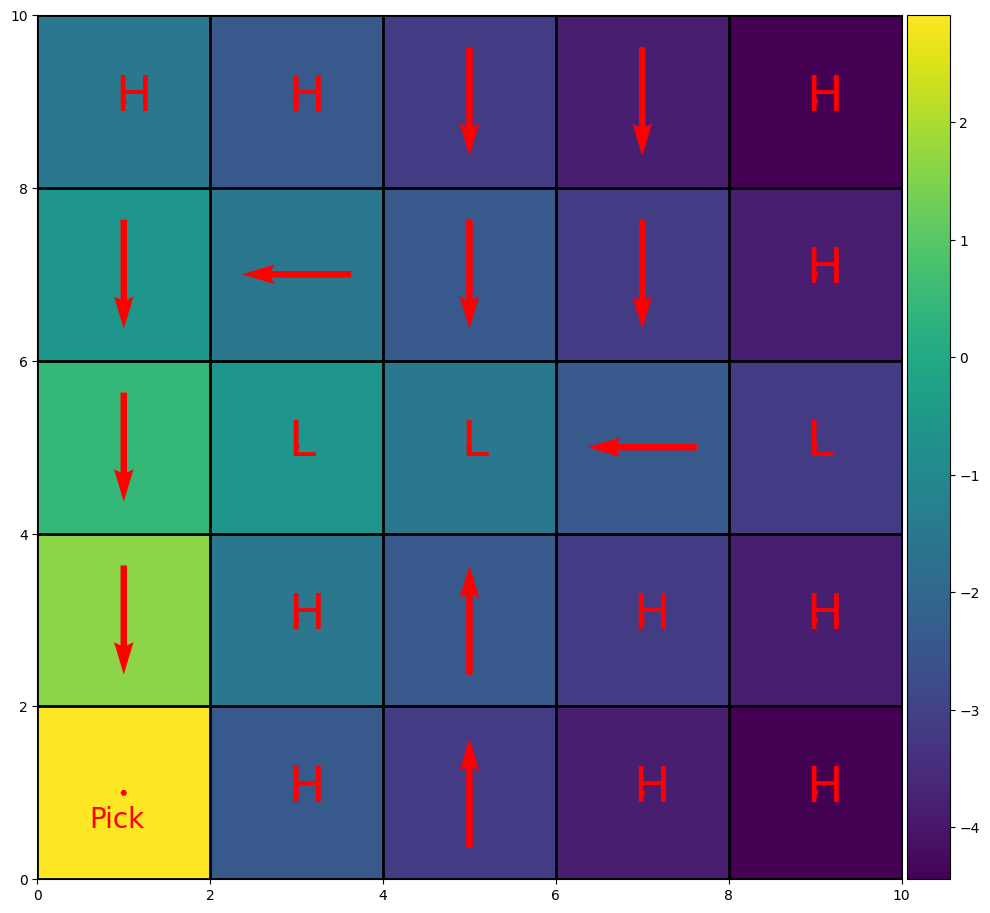

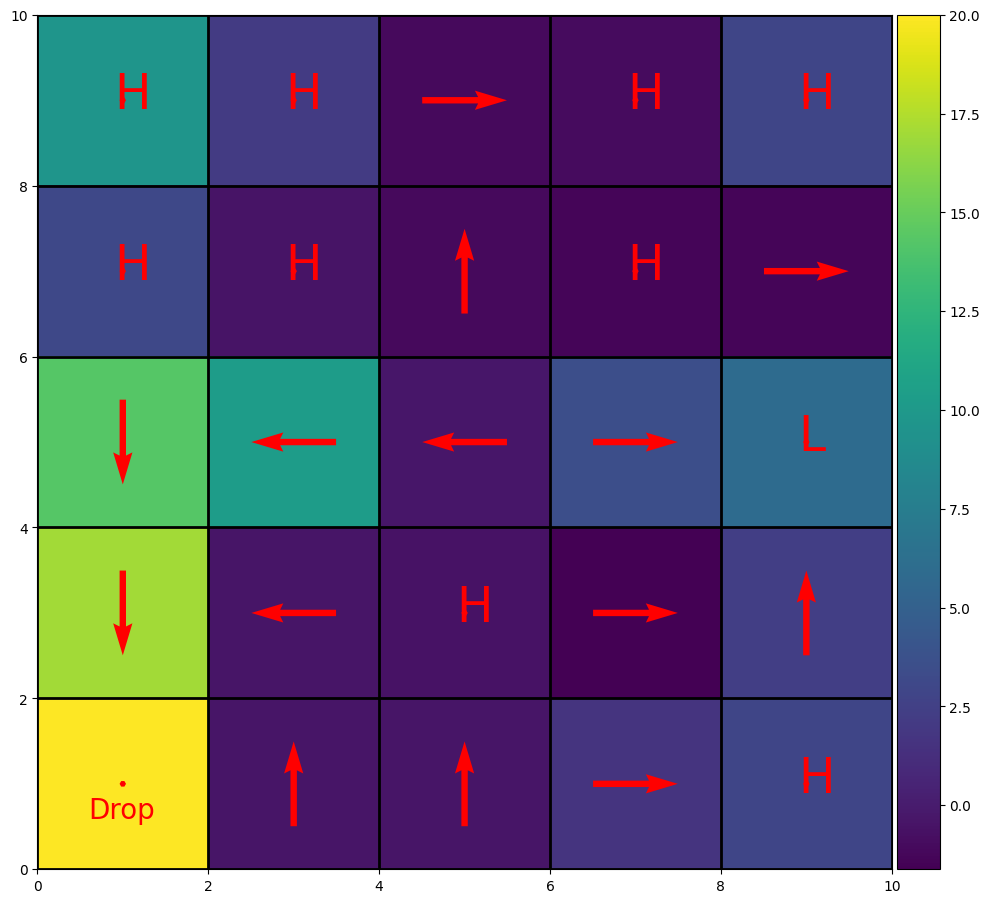

In [154]:
visualise_q(op_SMDP_q1[2],op_SMDP_1[2],'0')
visualise_q(op_SMDP_q2[2],op_SMDP_2[2],"1")

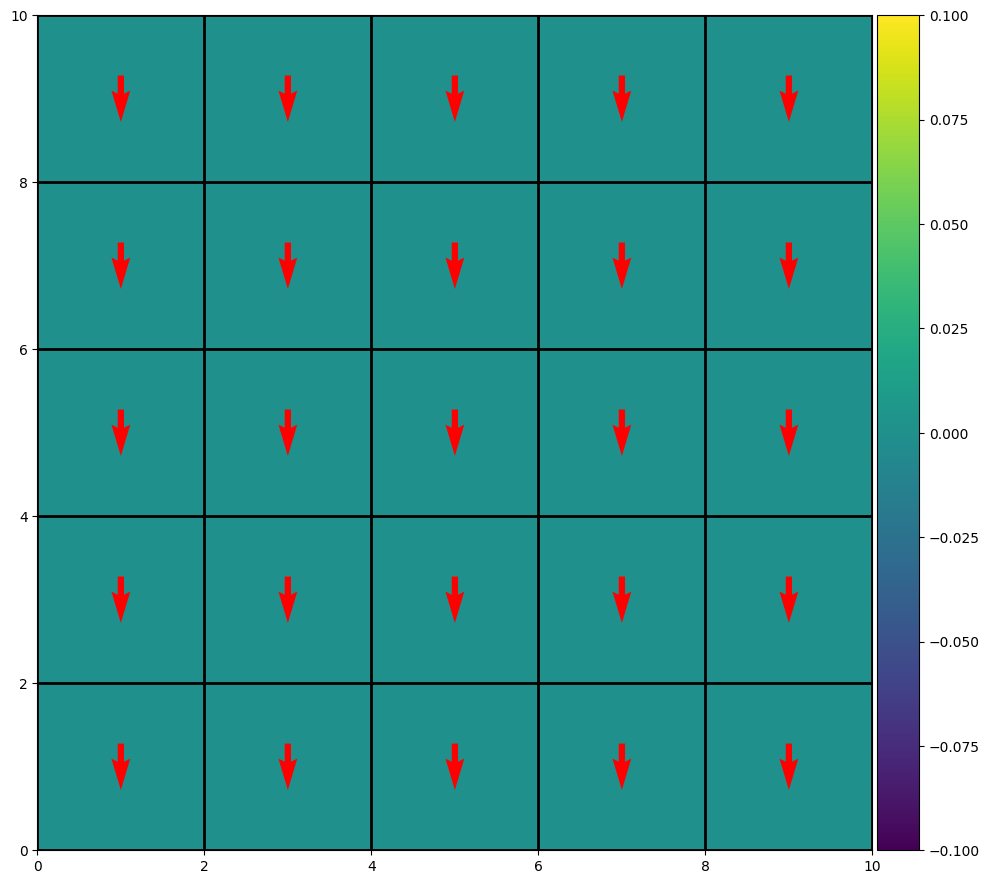

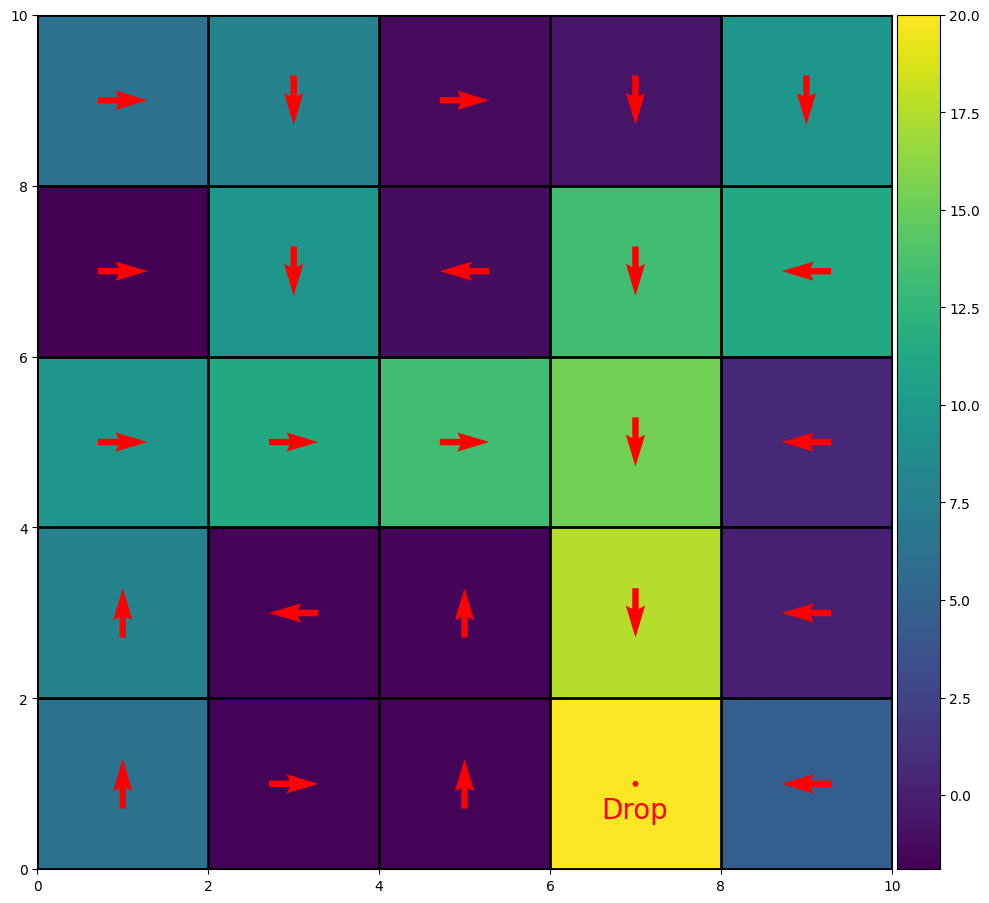

In [163]:
visualise_q(op_intra_q1[3],op_intra_1[3],'0')
visualise_q(op_intra_q2[3],op_intra_2[3],'1')

In [149]:
def freq_heat(m1):
  fig, ax = plt.subplots(figsize = (10,10))
  im = ax.imshow(m1, extent=[0, 10, 0, 10])
  ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im, cax=cax, orientation='vertical')